# Filter Analysis
**In this notebook, we analyze the results of applying 5 filters to a HfO2 thin film on a Si subtrate, with the end goal of removing unwanted diffraction peaks while maintaining a desirable signal:noise ratio.**

*Date: 06/24/2024*

*Author: Sonia Ghoshal, NIST SURF*
## 1.1. Setup
### Chip Details:
* type: KRISS K157 #502
* thickness: 6.0nm
* composition: HfO2 over Si substrate
### Filter Details: 
* F0 = No filter
* F1 = Al 12.5μm
* F2 = Al 100μm
* F3 = Al 630μm
* F4 = Al 100μm, Ti 25μm
* F5 = Al 100μm, Ti 50μm, Cu 25μm
### General info:
* reading .txt format
* mapping Si and Hf net counts, roi net counts, roi background net counts
* raw > process directories

### Files and directories used for fitting
- specify the location to load .txt data (raw)
- specify the location to save processed results (data), and generated figures (data)
- specify file name
- specify new name extensions


In [1]:
#net sums .txt file names
ns1TextFile = 'KRISS157_T1_6nm_net_sums_2.txt'
ns2TextFile = 'net_sums_2.txt'
ns3TextFile = 'net_sums_3.txt'

#roi sums .txt file names
roi1TextFile = 'KRISS157_T1_6nm_roi_sums_2.txt'
roi2TextFile = 'roi_net_sums_2.txt'
roi3TextFile = 'roi_net_sums_3.txt'

#background roi sums .txt file names
bg_roi1TextFile = 'KRISS157_T1_6nm_roi_bg_sums_2.txt'
bg_roi2TextFile = 'roi_bg_sums_2.txt'
bg_roi3TextFile = 'roi_bg_sums_3.txt'

#Location in the raw directory where data is kept
T1Dir = '\\20240624_HfO2_Filter\\Trial 1\\Counts\\'
T2Dir = '\\20240624_HfO2_Filter\\Trial 2\\Counts\\'
T3Dir = '\\20240624_HfO2_Filter\\Trial 3\\Counts\\'

# TextFileDir = '20240624_HfO2_Filter\\Trial 1\\Counts'
TextFileStrip = 'interim'
# Sample = "T1"
#Sample_name = "6 nm "

## 1.2. Imports

In [2]:
import pickle as pkl
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import PyMca5 as mca
import os
import gzip
import re as re
import math
from importlib.metadata import version
%matplotlib inline

### 1.2.2. Building a Subdirectory Tree for Imports and Exports
* uses import os command to find current working directory of this notebook
* generates directory tree from this root location assuming a `cookiecutter` data science directory tree.

In [3]:
NoteBookDir = os.getcwd()
print(NoteBookDir)
NoteBookRootDir = os.path.split(NoteBookDir)[0]
print(NoteBookRootDir)

C:\Users\sng38\SURF_XRF_FY24\surf_xrf_fy24\notebooks\Primary Analysis
C:\Users\sng38\SURF_XRF_FY24\surf_xrf_fy24\notebooks


In [4]:
# Set by cookiecutter structure
FiguresSuffix = 'figures\\'
RawSuffix = '\\data\\raw\\'
InterimSuffix = '\\data\\interim\\'
ProcessedSuffix = '\\data\\processed\\'
ModelSuffix = '\\models\\'

# Find the Current Working Directory set by the notebook location
NoteBookDir = os.getcwd()
# find root of notebooks Directory
NoteBookRootDir = os.path.split(NoteBookDir)[0]
# Back up one directories (assuming that the notebook is inside a folder within the notebook root)
ProjectDir = os.path.split(NoteBookRootDir)[0]
# build directory links independent of OS and directory location of repo.
RawDir = ProjectDir + RawSuffix
InterimDir = ProjectDir + InterimSuffix
InterimFigDir = ProjectDir + InterimSuffix + FiguresSuffix
ProcessedDir = ProjectDir + ProcessedSuffix
ProcessedFigDir = ProjectDir + ProcessedSuffix + FiguresSuffix
ModelDir = ProjectDir + ModelSuffix

print("current notebook dir = ", NoteBookDir, "\nProject directory = ", ProjectDir, "\nraw directory = ", RawDir, "\ninterim directory = ",InterimDir, 
      "\ninterim figures directory = ", InterimFigDir, "\nprocessed directory = ", ProcessedDir,"\nprocessed figures directory = ",ProcessedFigDir,
      "\nmodels directory = ", ModelDir)
print(RawDir+T1Dir+ns1TextFile)

current notebook dir =  C:\Users\sng38\SURF_XRF_FY24\surf_xrf_fy24\notebooks\Primary Analysis 
Project directory =  C:\Users\sng38\SURF_XRF_FY24\surf_xrf_fy24 
raw directory =  C:\Users\sng38\SURF_XRF_FY24\surf_xrf_fy24\data\raw\ 
interim directory =  C:\Users\sng38\SURF_XRF_FY24\surf_xrf_fy24\data\interim\ 
interim figures directory =  C:\Users\sng38\SURF_XRF_FY24\surf_xrf_fy24\data\interim\figures\ 
processed directory =  C:\Users\sng38\SURF_XRF_FY24\surf_xrf_fy24\data\processed\ 
processed figures directory =  C:\Users\sng38\SURF_XRF_FY24\surf_xrf_fy24\data\processed\figures\ 
models directory =  C:\Users\sng38\SURF_XRF_FY24\surf_xrf_fy24\models\
C:\Users\sng38\SURF_XRF_FY24\surf_xrf_fy24\data\raw\\20240624_HfO2_Filter\Trial 1\Counts\KRISS157_T1_6nm_net_sums_2.txt


### 1.2.3. Importing data from .txt files
- Unfortunately, the .txt files for the net counts, ROI counts, and Background ROI counts are not formatted in identical ways. Thus, parsing through the files could not be streamlined - each file has to be read slightly differently. 

In [6]:
NetSum1 = pd.read_csv(RawDir + T1Dir + ns1TextFile, sep = ' ', skiprows = 2, skipfooter=5, comment = '-', skipinitialspace=True, 
                           engine = 'python')

roiSum1 = pd.read_csv(RawDir + T1Dir + roi1TextFile, sep = ' ', skiprows = 2, skipfooter=6, comment = '-', skipinitialspace=True, 
                           engine = 'python')

bg_roiSum1 = pd.read_csv(RawDir + T1Dir + bg_roi1TextFile,  sep = ' ', skiprows = 2, skipfooter=6, comment = '--', skipinitialspace=True, 
                           engine = 'python')

#We will delete the 'Spectrum' column. It'll be easier in the next step if all of the values are integers. 
# The row (index) signifies the filter used.
del NetSum1['Spectrum']
del roiSum1['Spectrum']
del bg_roiSum1['Spectrum']

#For some reason, the background ROI values read in as negative values. We change them to all be positive numbers. 
bg_roiSum1 = bg_roiSum1.multiply(-1)

#print("\n", NetSum1)
#print("\n", roiSum1)
#print("\n", bg_roiSum1)



## 1.3. Analyzing Signal:Noise and Relative Uncertainties
Here, we divide the Hf ROI counts by the background ROI counts to normalize and thus obtain a ratio that signifies signal:noise. Then we find the relative uncertainties of the net counts, ROI counts, and background ROI counts with the formula $\sqrt{n}/n$, and combine all of this data in one table.

In [9]:
# division of ROI counts by Background ROI counts (signal:noise). We only care about the Hf counts, not Si or Rh.
norm_1 = roiSum1.div(bg_roiSum1)
del norm_1['Rh']
del norm_1['Si']

#Convert Hf net counts, ROI counts, background ROI counts, and normalized ROI counts to lists
Hf_net_1 = NetSum1['Hf'].to_list()
Hf_roi_1 = roiSum1['Hf'].to_list()
Hf_bg_roi_1 = bg_roiSum1['Hf'].to_list() 
Hf_norm_1 = norm_1['Hf'].to_list()

#relative uncertainty as a percent is 100 * sqrt(n)/n
net_rel_uncer = []
for a in range(len(Hf_net_1)):
    net_rel_uncer.append(math.sqrt(Hf_net_1[a]) * 100 / Hf_net_1[a])

roi_rel_uncer = []
for j in range(len(Hf_roi_1)):
    roi_rel_uncer.append(math.sqrt(Hf_roi_1[j]) * 100 / Hf_roi_1[j])

bg_roi_rel_uncer = []
for k in range(len(Hf_bg_roi_1)):
    #catch cases to avoid dividing by 0
    if Hf_bg_roi_1[k] != 0: 
        bg_roi_rel_uncer.append(math.sqrt(Hf_bg_roi_1[k]) * 100 / (Hf_bg_roi_1[k]))
    else: 
        bg_roi_rel_uncer.append('inf')

data1 = {
    "Filter":['F0', 'F1', 'F2', 'F3', 'F4', 'F5'],
    "Hf Net Counts": Hf_net_1,
    "Hf Signal:Noise":Hf_norm_1,
    "Net Counts δ(%)": net_rel_uncer,
    "ROI δ(%)":roi_rel_uncer,
    "BG ROI δ(%)": bg_roi_rel_uncer,
}

Hf_df_1 = pd.DataFrame(data1)
Hf_df_1 = Hf_df_1.set_index('Filter')
Hf_df_1

,Hf Net Counts,Hf Signal:Noise,Net Counts δ(%),ROI δ(%),BG ROI δ(%)
Filter,,,,,
F0,8970,2.190375,1.055854,1.394414,2.063721
F1,7244,2.240193,1.174927,1.548760,2.318071
F2,3845,5.051044,1.612693,2.143240,4.816831
F3,713,inf,3.745029,5.212860,inf
F4,950,inf,3.244428,4.323377,inf
F5,114,inf,9.365858,12.598816,inf


## 1.3.1. Plotting Net Counts over Signal:Noise 
Here, we examine the tradeoff between having a "cleaner" signal (higher signal:noise ratio) and having a "stronger" signal (higher net Hf counts). Our goal is to examine whether any of the filters clean up the background noise without significantly reducing the amplitude of the Hf signal. 

The graph below plots the signal:noise ratio on the x-axis and the Hf net counts on the y axis. Therefore the most "outward" point from the origin maximizes both of these two qualities. 

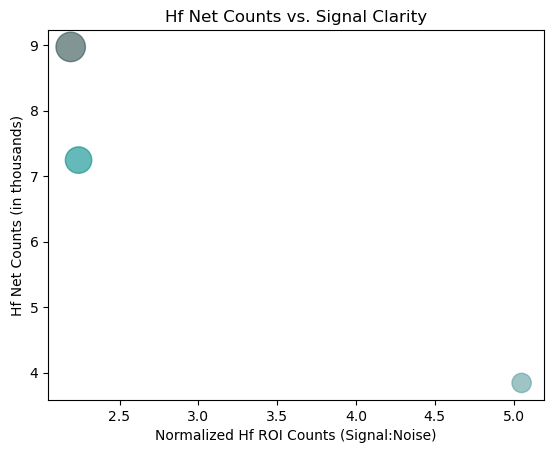

In [105]:
# We are excluding the 3rd-5th filters because they resulted in inf Signal:Noise ratios
x_data = Hf_norm_1[0:3]
y_data = Hf_net_1[0:3]

fig, ax = plt.subplots()
# QUESTION: How do we find the optimal point quantitatively?
opt = [0,0,0]
for i in range(3):
    opt[i] = math.sqrt(Hf_norm_1[i] ** 2 + Hf_net_1[i] ** 2) / 20
# add labels to all points
labels = ['F0', 'F1', 'F2']

ax.scatter(x_data, [y / 1000 for y in y_data], label = labels, c = ["darkslategrey", "darkcyan", "cadetblue"], s = opt, alpha = 0.6)

# for i, label in enumerate(labels):
#     ax.text(x_data[i], y_data[i], "hi" )

plt.title("Hf Net Counts vs. Signal Clarity")
plt.xlabel("Normalized Hf ROI Counts (Signal:Noise)")
plt.ylabel("Hf Net Counts (in thousands)")
plt.legend()

#plt.savefig(ProcessedFigDir + Sample + 'Si_Z-score_post_clean' + '.png', dpi=600)
plt.show()

The sizes of the bubbles above correspond to how "optimal" each point is (i.e. how much it maximizes both axes). We see that F0 (no filter) is the most optimal case.

In [95]:
help(plt.text)

Help on function text in module matplotlib.pyplot:

text(x: 'float', y: 'float', s: 'str', fontdict: 'dict[str, Any] | None' = None, **kwargs) -> 'Text'
    Add text to the Axes.

    Add the text *s* to the Axes at location *x*, *y* in data coordinates,
    with a default ``horizontalalignment`` on the ``left`` and
    ``verticalalignment`` at the ``baseline``. See
    :doc:`/gallery/text_labels_and_annotations/text_alignment`.

    Parameters
    ----------
    x, y : float
        The position to place the text. By default, this is in data
        coordinates. The coordinate system can be changed using the
        *transform* parameter.

    s : str
        The text.

    fontdict : dict, default: None

        .. admonition:: Discouraged

           The use of *fontdict* is discouraged. Parameters should be passed as
           individual keyword arguments or using dictionary-unpacking
           ``text(..., **fontdict)``.

        A dictionary to override the default text properti